in this notebook, FEF model in [Pesaran, M. Hashem; Zhou, Qiankun (2014) : Estimation of Time-invariant Effects in Static Panel Data Models] (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2493312) is applied to estimate the effect of time-invariant variables, altruism, in the panel data.

I wrote this in Stata first to ensure the correctness of applying statistic models, then writing this again in Python for the completeness of the project and to practice.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from auxiliary import *
import zipfile
from linearmodels.panel import PooledOLS, RandomEffects, BetweenOLS, FirstDifferenceOLS

import statsmodels.api as sm
import missingno as msno

pd.set_option('display.max_columns', 500)

sns.set_theme(style="ticks")

In [ ]:
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

### read in data
### set up dependent and independent variables
### examine missing value

In [2]:
long = pd.read_csv('data/result_long.csv')

#setting variables
#time invariants
x = ['altruism', 'posrecip', 'risktaking', 'patience', 'trust', 'negrecip', 'income_type', 'region']

#dummy vars
x_dummy = ['oecd', 'g20', 'oda_int', 'aid']

#year-varied vars 
x_year = ['demo_electoral', 'demo_gov', 'demo_participate', 'demo_culture', 'demo_liberty', 'govexpense',  'gdpcapita']

#year-varied gini index, contains large numbers of na
gni = ['gni']

#add constant
long_c = sm.add_constant(long)
long_y = long_c.assign(funding_capita= long_c['funding']/long_c['pop'])

long_replace = long_y.replace({'funding_capita': np.nan}, 0)
long_index = long_replace.set_index(['isocode', 'year'])
long_select_gni = long_index[['funding_capita'] + x + x_dummy + x_year + gni]
long_select_gni.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1368 entries, ('AFG', 2003) to ('ZWE', 2020)
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   funding_capita    1368 non-null   float64
 1   altruism          1368 non-null   float64
 2   posrecip          1368 non-null   float64
 3   risktaking        1368 non-null   float64
 4   patience          1368 non-null   float64
 5   trust             1368 non-null   float64
 6   negrecip          1368 non-null   float64
 7   income_type       1368 non-null   object 
 8   region            1368 non-null   object 
 9   oecd              1368 non-null   int64  
 10  g20               1368 non-null   int64  
 11  oda_int           1368 non-null   int64  
 12  aid               1368 non-null   int64  
 13  demo_electoral    912 non-null    float64
 14  demo_gov          912 non-null    float64
 15  demo_participate  912 non-null    float64
 16  demo_culture      912

### graoh for examine missing value
- democratic have no data for 2007, 2009 and before 2006 simply bcs the assessment wasn't held in those years
- relatively small amount of missing value in govexpense & gdpcapita
- gni have large number of missing value for non-specific reason

<AxesSubplot:>

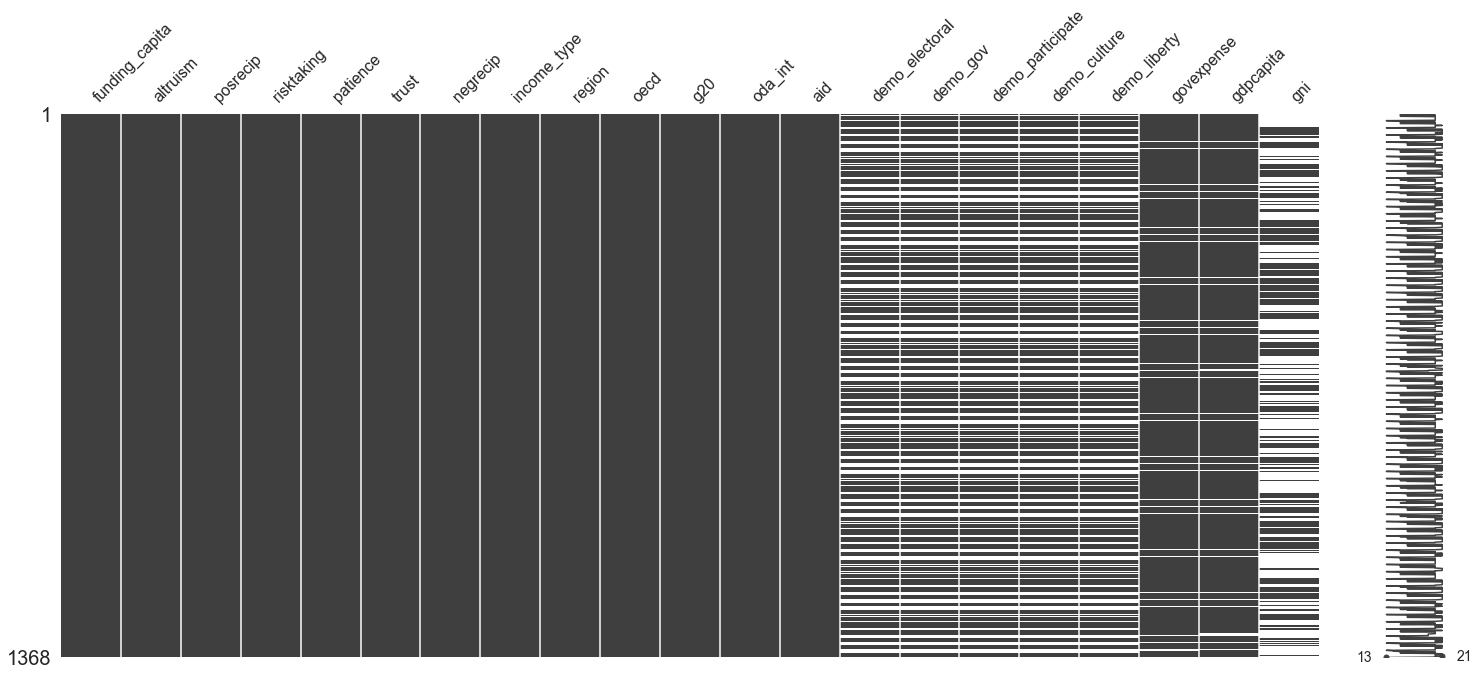

In [4]:
msno.matrix(long_select_gni)

### plot the relationship between y and x by missing gini index or not
### doesn't looks like missing at completely random
 in this notebook the result include and exclude gini index would be seperated, it's an influential factors based on past research, but the large number of missing value is not MACR and may causes bias. 

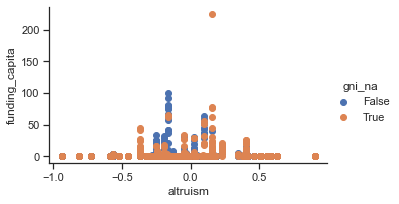

In [28]:
long_select_gni_na = long_select_gni.assign(gni_na=long_select_gni.gni.isnull())
fg = sns.FacetGrid(data=long_select_gni_na, hue='gni_na', aspect=1.61)
fg.map(plt.scatter, 'altruism', 'funding_capita').add_legend()


In [32]:
#drop na for regression
long_select = long_select_gni.drop(columns='gni')

df = long_select.dropna()
df_gni = long_select_gni.dropna()

df.head()


funding_capita  altruism  posrecip  risktaking  patience  \
isocode year                                                             
AFG     2006        0.000000  0.166455  0.289641    0.120764  -0.20136   
        2008        0.865730  0.166455  0.289641    0.120764  -0.20136   
        2010        0.081544  0.166455  0.289641    0.120764  -0.20136   
        2011        0.000112  0.166455  0.289641    0.120764  -0.20136   
        2012        0.000096  0.166455  0.289641    0.120764  -0.20136   

                 trust  negrecip income_type      region  oecd  g20  oda_int  \
isocode year                                                                   
AFG     2006  0.315964  0.254712  Low income  South Asia     0    0        0   
        2008  0.315964  0.254712  Low income  South Asia     0    0        0   
        2010  0.315964  0.254712  Low income  South Asia     0    0        0   
        2011  0.315964  0.254712  Low income  South Asia     0    0        0   
        2012  0.315964  0.254712  Low income  South Asia     0    0        0   

              aid  demo_electoral  demo_gov  demo_participate  demo_culture  \
isocode year                                                                  
AFG     2006    0            61.7       0.0              22.2          25.0   
        2008    0            51.7       7.9              22.2          25.0   
        2010    0            25.0       7.9              27.8          25.0   
        2011    0            25.0       7.9              27.8          25.0   
        2012    0            25.0       7.9              27.8          25.0   

              demo_liberty  govexpense   gdpcapita  
isocode year                                        
AFG     2006          44.1      18.303  263.733692  
        2008          44.1      20.918  364.660745  
        2010          38.2      20.801  543.303042  
        2011          38.2      21.937  591.162759  
        2012          38.2      25.028  641.871479

# FEF
### STEP 1: panel fixed effect model 

In [34]:
#with gni
mod = PooledOLS(df_gni.funding_capita, df_gni[x_year + gni])
pooled_res_gni = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, entity_effects=True)

#without gni
mod = PooledOLS(df.funding_capita, df[x_year])
pooled_res = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, entity_effects=True)
pooled_res

Dep. Variable:,funding_capita,R-squared:,0.4568
Estimator:,PooledOLS,R-squared (Between):,0.6176
No. Observations:,905,R-squared (Within):,0.0104
Date:,"Fri, Jan 01 2021",R-squared (Overall):,0.4568
Time:,02:21:00,Log-likelihood,-3440.2
Cov. Estimator:,Clustered,,
,,F-statistic:,107.89
Entities:,76,P-value,0.0000
Avg Obs:,11.908,Distribution:,"F(7,898)"
Min Obs:,7.0000,,
Max Obs:,12.000,F-statistic (robust):,4.9805
